In [1]:
import pandas as pd
import numpy as np
import datetime as dt

from spacepy import coordinates as coord
from spacepy.time import Ticktock

In [2]:
base_f_loc = '/storage/silver/stfc_cg/hf832176/data/THEMIS/'

# <center> Read in Data </center>

In [3]:
!ls {base_f_loc}*.pkl

/storage/silver/stfc_cg/hf832176/data/THEMIS/tha_esa_energy_levels.pkl
/storage/silver/stfc_cg/hf832176/data/THEMIS/tha_mag.pkl
/storage/silver/stfc_cg/hf832176/data/THEMIS/tha.pkl
/storage/silver/stfc_cg/hf832176/data/THEMIS/tha_sst_energy_levels.pkl
/storage/silver/stfc_cg/hf832176/data/THEMIS/thb_mag.pkl
/storage/silver/stfc_cg/hf832176/data/THEMIS/thb.pkl
/storage/silver/stfc_cg/hf832176/data/THEMIS/thc_mag.pkl
/storage/silver/stfc_cg/hf832176/data/THEMIS/thc.pkl
/storage/silver/stfc_cg/hf832176/data/THEMIS/thd_mag.pkl
/storage/silver/stfc_cg/hf832176/data/THEMIS/thd.pkl
/storage/silver/stfc_cg/hf832176/data/THEMIS/the_mag.pkl
/storage/silver/stfc_cg/hf832176/data/THEMIS/the.pkl


In [4]:
e_levs_sst = pd.read_pickle(base_f_loc+'tha_sst_energy_levels.pkl')
display(e_levs_sst.T)
e_levs_esa = pd.read_pickle(base_f_loc+'tha_esa_energy_levels.pkl')
display(e_levs_esa.T)

e_levs = [i for i in e_levs_esa.index[::-1]]+[i for i in e_levs_sst.index]
# display(e_levs)

,31000.0,41000.0,52000.0,65500.0,93000.0,139000.0,203500.0,293000.0,408000.0,561500.0,719500.0,NaN,NaN,NaN,NaN,NaN
eV,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15


,31766.636719,26831.396484,20383.251953,15484.854492,11763.428711,8936.366211,6788.923828,5157.255371,3917.749512,2976.849854,...,83.861748,63.502251,48.474998,36.841000,28.115499,20.844250,15.996750,12.603500,9.210250,7.271250
eV,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31


In [5]:
# Read .pkl files
tha = pd.read_pickle(base_f_loc+'tha.pkl')
thb = pd.read_pickle(base_f_loc+'thb.pkl')
thc = pd.read_pickle(base_f_loc+'thc.pkl')
thd = pd.read_pickle(base_f_loc+'thd.pkl')
the = pd.read_pickle(base_f_loc+'the.pkl')

In [6]:
# tha.columns.tolist()[:32][::-1]
# [i+1 for i in range(32)]
# ['esa_E_'+str(i+1) for i in range(32)]+tha.columns.tolist()[32:]

In [7]:
# reorder sst columns by ascending energy
cols = tha.columns.tolist()[:32][::-1]+['E_'+str(i+1) for i in range(16)]+tha.columns.tolist()[48:]
tha = tha[cols]
thb = thb[cols]
thc = thc[cols]
thd = thd[cols]
the = the[cols]

# Reorder esa columns by ascending energy
tha.columns = ['esa_E_'+str(i+1) for i in range(32)]+tha.columns.tolist()[32:]
thb.columns = ['esa_E_'+str(i+1) for i in range(32)]+tha.columns.tolist()[32:]
thc.columns = ['esa_E_'+str(i+1) for i in range(32)]+tha.columns.tolist()[32:]
thd.columns = ['esa_E_'+str(i+1) for i in range(32)]+tha.columns.tolist()[32:]
the.columns = ['esa_E_'+str(i+1) for i in range(32)]+tha.columns.tolist()[32:]

In [8]:
# Coordinate transform
def get_c_init(spacecraft):
    '''
    Given a THEMIS spacecraft dataframe, function
    extracts and formats the GSM position into list
    of [x,y,z]
       
    Returns list'''
    my_coords = [np.array([x,y,z])/6378.1
                 for x,y,z in zip(spacecraft['pos_x_gsm'],
                                  spacecraft['pos_y_gsm'],
                                  spacecraft['pos_z_gsm'])]
    return my_coords

def tttime(spacecraft):
    '''Converting from datetimes to Ticktock times
       
       Returns Ticktock time list'''
    tt = Ticktock([i for i in spacecraft.index], dtype='UTC')
    return tt

def get_c_final(spacecraft):
    '''
    Converts the GSM coordinates into GMAG coordinates.
    Returns GMAG in cartesian and spherical coordinates
    '''
    my_coords = get_c_init(spacecraft)
    cvals = coord.Coords(data = my_coords,
                         dtype = 'GSM',
                         carsph = 'car',
                         units = ['Re', 'Re', 'Re'])
    
    cvals.ticks = tttime(spacecraft)
    newcvals = cvals.convert('MAG', 'car')
    mltcvals = cvals.convert('MAG', 'sph')
    return (newcvals,mltcvals)

def c_to_df(spacecraft,scstr,base_f_loc):
    '''
    Extracts the x, y and z and r, lat, lon coordinates from
    the conversion.
    Calculates MLT from the longitute.
    Appends data to DFs and saves DFs
    '''
    newcvals, mltcvals = get_c_final(spacecraft)
    
    pos_x_mag = newcvals.x
    pos_y_mag = newcvals.y
    pos_z_mag = newcvals.z

    pos_r_mag = mltcvals.radi
    pos_lat_mag = mltcvals.lati
    pos_lon_mag = mltcvals.long

    mlt_mag = [i*12/180 if i >= 0 else (12+np.abs(i)*12/180) for i in pos_lon_mag]
    
    var_names = ['pos_x_mag','pos_y_mag','pos_z_mag',
                 'pos_r_mag','pos_lat_mag','pos_lon_mag',
                 'mlt_mag']
    variables = [pos_x_mag,pos_y_mag,pos_z_mag,
                 pos_r_mag,pos_lat_mag,pos_lon_mag,
                 mlt_mag]
    
    for i,j in zip(var_names,variables):
        spacecraft[i] = j
        
    spacecraft.to_pickle(base_f_loc+scstr+'_mag.pkl')

    return spacecraft

In [9]:
tha = c_to_df(tha,'tha',base_f_loc)
thb = c_to_df(thb,'thb',base_f_loc)
thc = c_to_df(thc,'thc',base_f_loc)
thd = c_to_df(thd,'thd',base_f_loc)
the = c_to_df(the,'the',base_f_loc)

In [10]:
# DEF to PSD
def def_2_psd(defs,e_channel):
    m_e = 9.1093*10**-31
    c = 299792458
    eV = 1.602*10**-19
    
    defs = np.array(defs)
    defs_si = defs/(10**-6)
    
    energy = e_channel*eV# + m_e*c**2
    
#     psd = (defs_si*(m_e**2))/(2*(energy**2))
    psd = (defs_si*(c**2))/((energy**2)+2*m_e*(c**2)*energy)
    
    return psd

def psd_to_df(df,e_levels):
    for i in range(len(e_levels)):
        column = df.columns[i]
        at_energy = e_levels[i]
        df[column+'_psd'] = def_2_psd(df[column],at_energy)
        
    return df

In [11]:
# psd_to_df(tha,e_levs)
tha = psd_to_df(tha,e_levs)
thb = psd_to_df(thb,e_levs)
thc = psd_to_df(thc,e_levs)
thd = psd_to_df(thd,e_levs)
the = psd_to_df(the,e_levs)

$\theta$ increases clockwise for y>0 between 0 and 180

$\theta$ decreases anti-clockwise for y<0 between 0 and -180

# <center> Select Equatorial Data </center>

For analysis, data is limited to the equatorial plane and radial limits about an estimate of the ORB boundary.

Equatorial region: Z = 0 $\pm$ 0.5 R$_E$.

Radial limits: 7 R$_E$ $\leqslant$ R $\leqslant$ 12 R$_E$

Dawn (Dusk): 6 (18) $\pm$ 3 MLT 

In [12]:
def how_much(df):
    equa_r = df[(np.abs(df['pos_z_mag'])<0.5) &
                 (df['pos_r_mag'] >= 5) & (df['pos_r_mag'] <= 15)]
    dawn = equa_r[(3 <= equa_r['mlt_mag']) &
                  (equa_r['mlt_mag'] <= 9)]
    dusk = equa_r[(15 <= equa_r['mlt_mag']) &
                  (equa_r['mlt_mag'] <= 21)]
    print('DF: '+str(len(df)),'EQR: '+str(len(equa_r)),'Dawn: '+str(len(dawn)),'Dusk: '+str(len(dusk)))
    return dawn,dusk

In [13]:
a_dawn, a_dusk = how_much(tha)
b_dawn, b_dusk = how_much(thb)
c_dawn, c_dusk = how_much(thc)
d_dawn, d_dusk = how_much(thd)
e_dawn, e_dusk = how_much(the)

DF: 445922 EQR: 97071 Dawn: 24391 Dusk: 22219
DF: 445520 EQR: 6904 Dawn: 1770 Dusk: 2697
DF: 445921 EQR: 22647 Dawn: 7929 Dusk: 10586
DF: 445920 EQR: 74799 Dawn: 29210 Dusk: 44490
DF: 445922 EQR: 58729 Dawn: 8492 Dusk: 40596


In [14]:
dawn = pd.concat([a_dawn,b_dawn,c_dawn,d_dawn,e_dawn],axis=0,
                 sort=False,ignore_index=False)
dusk = pd.concat([a_dusk,b_dusk,c_dusk,d_dusk,e_dusk],axis=0,
                 sort=False,ignore_index=False)
print(dawn.shape,dusk.shape)

(71792, 119) (120588, 119)


Note:

Checking the date ranges for Dawn and Dusk shows that they haven't been swapped around during processing.

In [15]:
# Reordering PSD
subset = ['esa_E_1_psd', 'esa_E_2_psd', 'esa_E_3_psd', 'esa_E_4_psd',
          'esa_E_5_psd', 'esa_E_6_psd', 'esa_E_7_psd', 'esa_E_8_psd',
          'esa_E_9_psd', 'esa_E_10_psd', 'esa_E_11_psd', 'esa_E_12_psd',
          'esa_E_13_psd', 'esa_E_14_psd', 'esa_E_15_psd', 'esa_E_16_psd',
          'esa_E_17_psd', 'esa_E_18_psd', 'esa_E_19_psd', 'esa_E_20_psd',
          'esa_E_21_psd', 'esa_E_22_psd', 'esa_E_23_psd', 'esa_E_24_psd',
          'esa_E_25_psd', 'esa_E_26_psd', 'esa_E_27_psd', 'esa_E_28_psd',
          'esa_E_29_psd', 'esa_E_30_psd', 'esa_E_31_psd',
          'E_1_psd', 'E_2_psd', 'E_3_psd', 'E_4_psd', 'E_5_psd', 'E_6_psd',
          'E_7_psd', 'E_8_psd', 'E_9_psd', 'E_10_psd', 'E_11_psd']
dawn_f = dawn.dropna(subset=subset)
dusk_f = dusk.dropna(subset=subset)

dawn_f2 = dawn_f.drop(columns=['E_12_psd','E_13_psd','E_14_psd','E_15_psd',
                               'E_16_psd','esa_E_32_psd']).copy()
dusk_f2 = dusk_f.drop(columns=['E_12_psd','E_13_psd','E_14_psd','E_15_psd',
                               'E_16_psd','esa_E_32_psd']).copy()

e_levs2 = e_levs.copy()
e_levs2 = e_levs2[:31] + e_levs2[32:-5]
# e_levs2

# dawn_f.info(max_cols=200,null_counts=True)

In [16]:
dawn_f3 = dawn_f2.copy()
# Replacing 0 with np.nan in relevant columns
dawn_f3[dawn_f3.loc[:,dawn_f3.columns[71:]] == 0] = np.nan
# Dropping nans in relevant columns
dawn_f3 = dawn_f3.dropna(subset=dawn_f2.columns[71:])

dusk_f3 = dusk_f2.copy()
# Replacing 0 with np.nan in relevant columns
dusk_f3[dusk_f3.loc[:,dusk_f3.columns[71:]] == 0] = np.nan
# Dropping nans in relevant columns
dusk_f3 = dusk_f3.dropna(subset=dusk_f2.columns[71:])

In [17]:
def r_sampling(dawn_data,dusk_data,radial_bins):
    
    cats = np.histogram(dawn_data.r,bins=radial_bins,range=(5,15))
    dogs = np.histogram(dusk_data.r,bins=radial_bins,range=(5,15))
    minsamp = np.min([cats[0],dogs[0]])
    
    dawn_ss,dusk_ss = [],[]
    for i,j in zip(cats[1][:-1],cats[1][1:]):
        dawn_ss.append(dawn_data[(dawn_data.r > i) &
                                (dawn_data.r < j)]
                        .sample(n=minsamp))
        dusk_ss.append(dusk_data[(dusk_data.r > i) &
                                (dusk_data.r < j)]
                        .sample(n=minsamp))

    dawn_f4 = pd.concat(dawn_ss)
    dusk_f4 = pd.concat(dusk_ss)
    
    return(dawn_f4,dusk_f4)

In [18]:
da_f4,du_f4 = [],[]
for i in range(100):
    dawn_f4,dusk_f4 = r_sampling(dawn_f3,dusk_f3,20)
    da_f4.append(dawn_f4)
    du_f4.append(dusk_f4)
    
dawn_f5 = pd.concat(da_f4,ignore_index=True)
dusk_f5 = pd.concat(du_f4,ignore_index=True)

# <center> Plotting Data </center>

In [19]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
import seaborn as sbn

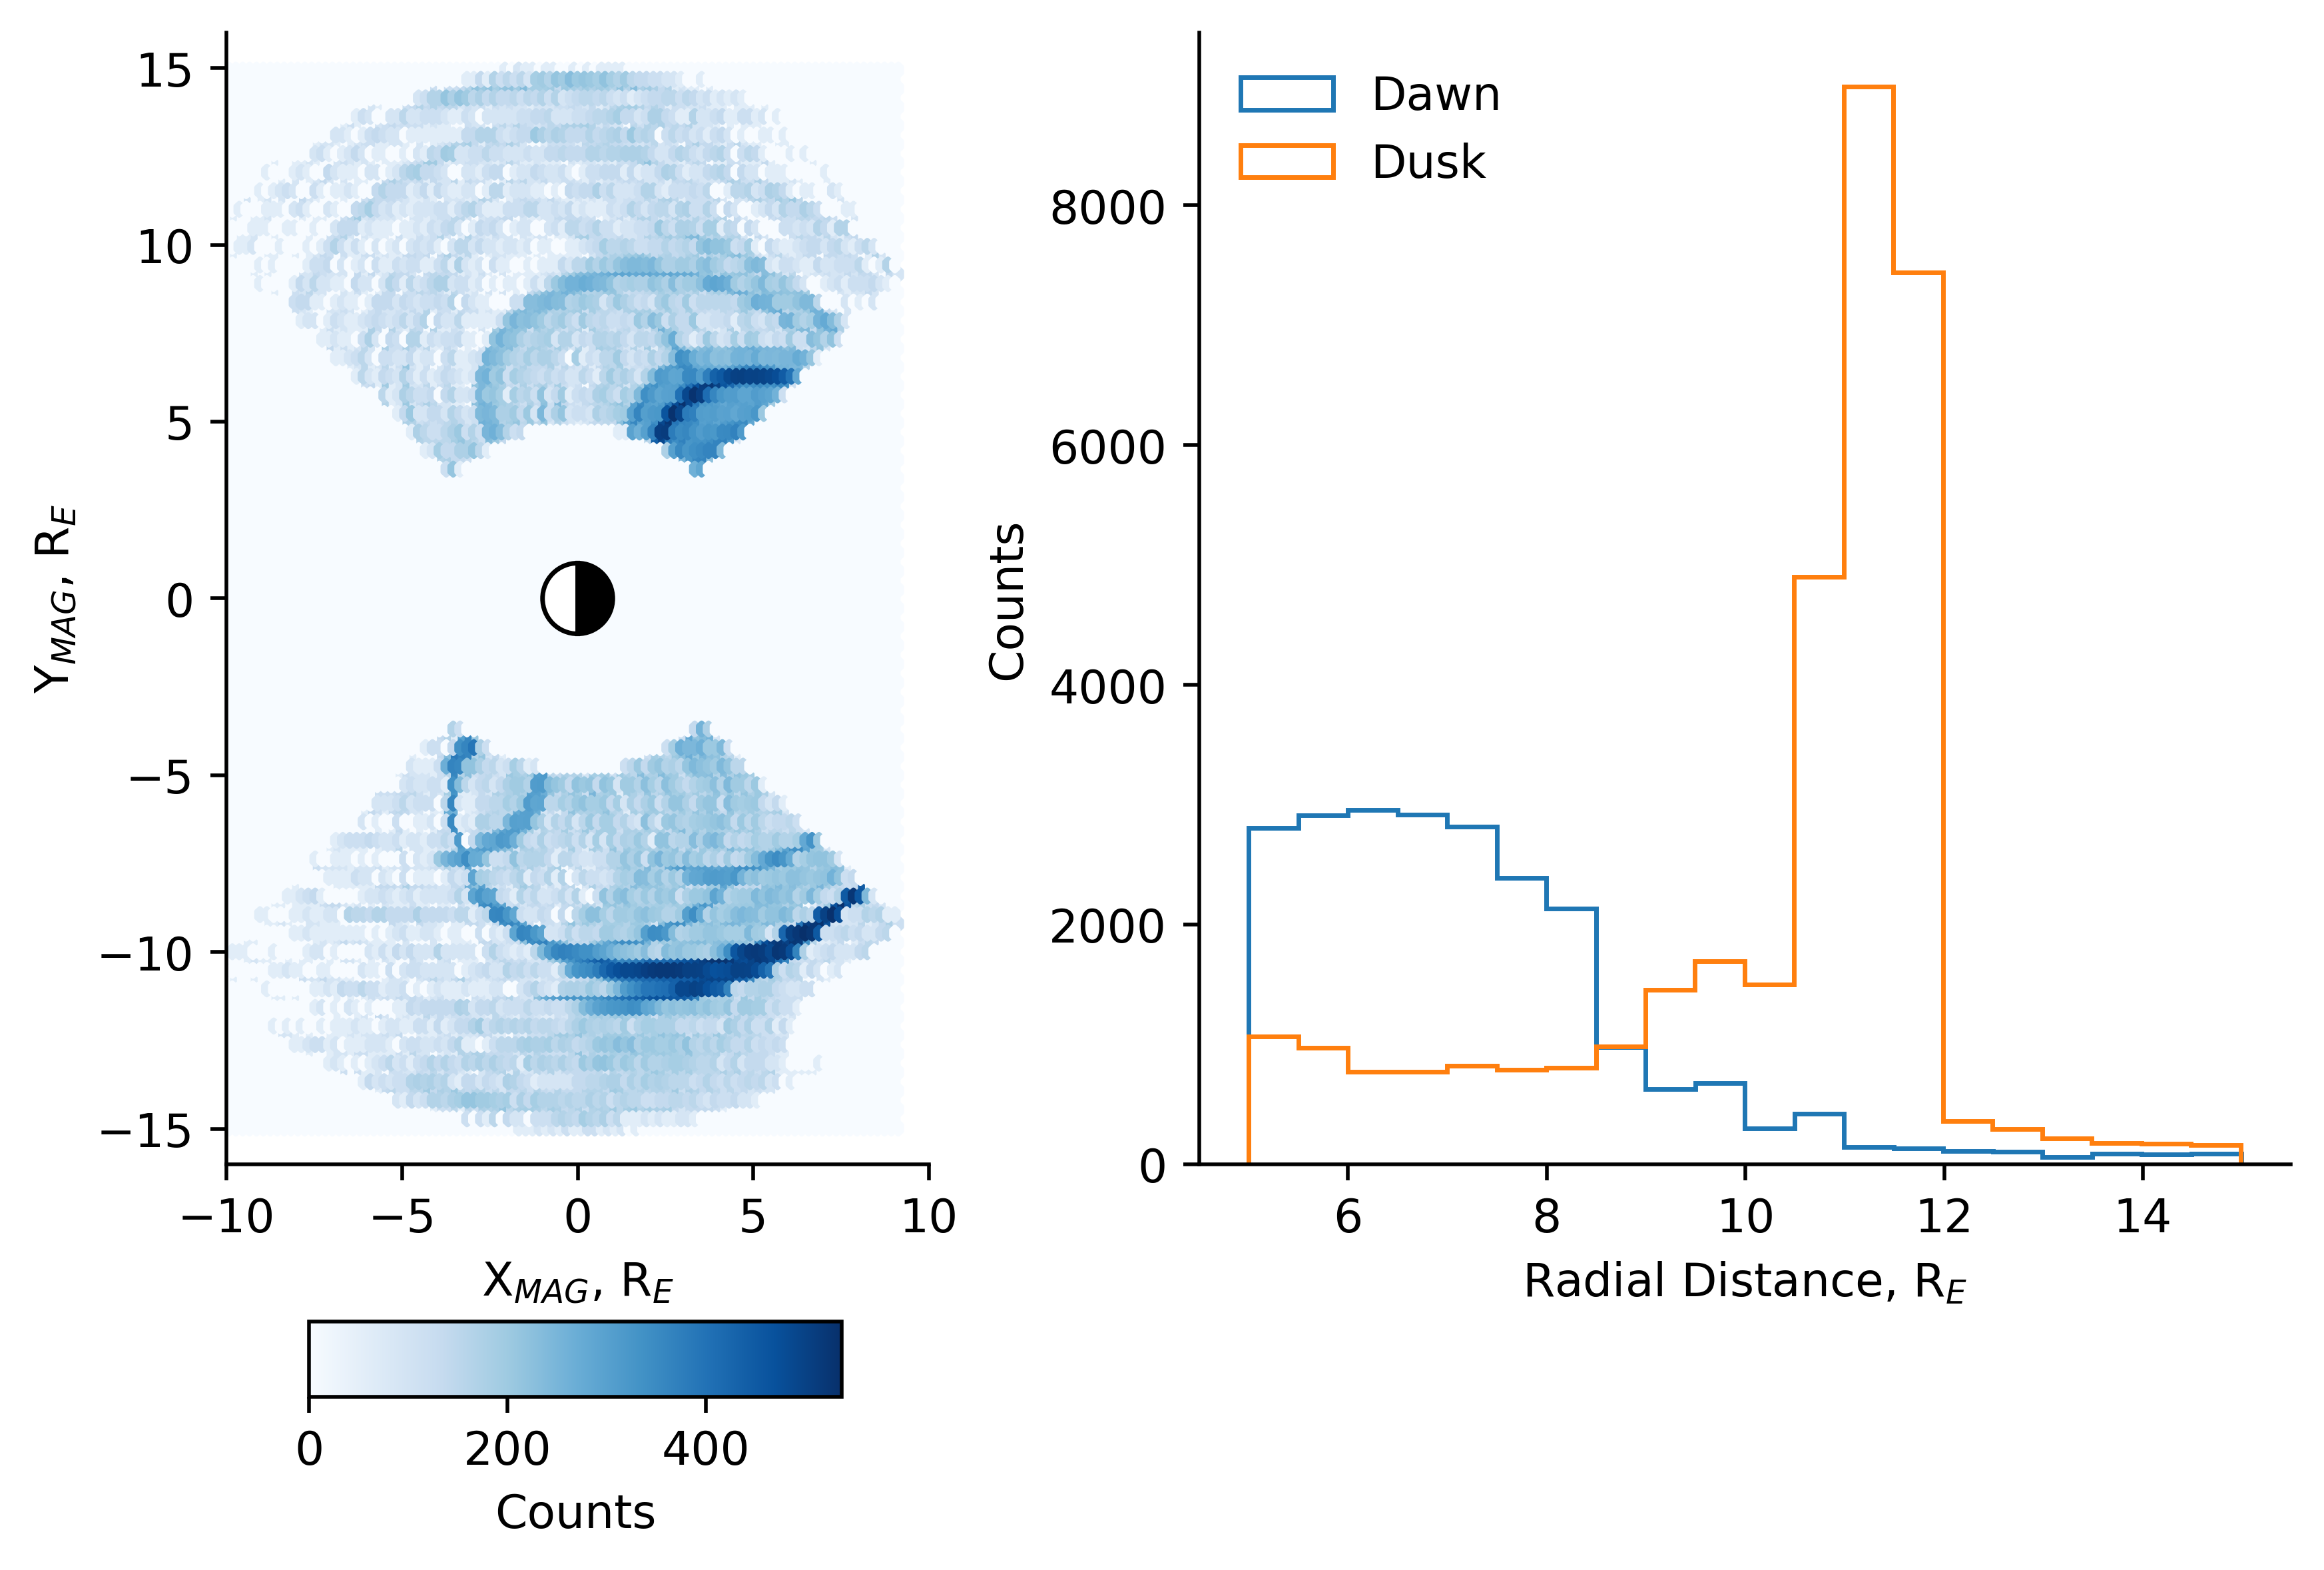

In [20]:
# Spatial distribution of data
fig = plt.figure(figsize=(8,4.5),dpi=500)
gs = mpl.gridspec.GridSpec(18,32)
ax1 = plt.subplot(gs[0:18,0:11])
ax2 = plt.subplot(gs[0:18,15:32])

hbp = ax1.hexbin(list(dawn_f2['pos_x_mag'].values)+
           list(dusk_f2['pos_x_mag'].values),
           list(dawn_f2['pos_y_mag'].values)+
           list(dusk_f2['pos_y_mag'].values),
           bins='log',cmap='Blues')

cmap = mpl.cm.get_cmap('Blues',len(dawn_f2)+len(dusk_f2))
norm = mpl.colors.Normalize(vmin=0, vmax=hbp.get_array().max())
cbaxes1 = fig.add_axes([0.156, -0.03, 0.2, 0.05]) 
cb1 = mpl.colorbar.ColorbarBase(cbaxes1, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')

ax1.add_artist(mpl.patches.Wedge((0,0),1,270,90,color='k'))
ax1.add_artist(mpl.patches.Wedge((0,0),1,90,270,color='w',ec='k'))

cb1.set_label('Counts')
ax1.set_ylabel('Y$_{MAG}$, R$_E$')
ax1.set_xlabel('X$_{MAG}$, R$_E$')
ax1.set_ylim(-16,16)
ax1.set_xlim(-10,10)
sbn.despine()

ax2.hist(dawn_f3['pos_r_mag'],bins=20,histtype='step',
         label='Dawn')
ax2.hist(dusk_f3['pos_r_mag'],bins=20,histtype='step',
         label='Dusk')


ax2.legend(loc='upper left',frameon=False)
ax2.set_ylabel('Counts')
ax2.set_xlabel('Radial Distance, R$_E$')

sbn.despine()

path = '/home/users/hf832176/My Documents/Coding/themis/Graphs/write_up/'
plt.savefig(fname = path+'data_coverage.pdf',format='pdf',bbox_inches='tight')
# plt.savefig(fname = path+'data_coverage.eps',format='eps',bbox_inches='tight')
plt.savefig(fname = path+'data_coverage.png',format='png',bbox_inches='tight')

plt.show()
# plt.close(fig)

In [24]:
# Plot of the radial dist. of median PSD
r_bins = np.linspace(5,15,10)
# print(r_bins)

r_def_da = [dawn_f5[(dawn_f5['pos_r_mag'] > i) &
                          (dawn_f5['pos_r_mag'] < j)].iloc[:,71:].median()
            for i,j in zip(r_bins[:-1],r_bins[1:])]

r_def_du = [dusk_f5[(dusk_f5['pos_r_mag'] > i) &
                          (dusk_f5['pos_r_mag'] < j)].iloc[:,71:].median()
            for i,j in zip(r_bins[:-1],r_bins[1:])]

#######

da_qu = [dawn_f5[(dawn_f5['pos_r_mag'] > i) &
                          (dawn_f5['pos_r_mag'] < j)].iloc[:,71:].quantile(0.90,axis=0)
            for i,j in zip(r_bins[:-1],r_bins[1:])]

da_ql = [dawn_f5[(dawn_f5['pos_r_mag'] > i) &
                          (dawn_f5['pos_r_mag'] < j)].iloc[:,71:].quantile(0.10,axis=0)
            for i,j in zip(r_bins[:-1],r_bins[1:])]

#######

du_qu = [dusk_f5[(dusk_f5['pos_r_mag'] > i) &
                          (dusk_f5['pos_r_mag'] < j)].iloc[:,71:].quantile(0.90,axis=0)
            for i,j in zip(r_bins[:-1],r_bins[1:])]

du_ql = [dusk_f5[(dusk_f5['pos_r_mag'] > i) &
                          (dusk_f5['pos_r_mag'] < j)].iloc[:,71:].quantile(0.10,axis=0)
            for i,j in zip(r_bins[:-1],r_bins[1:])]


# print(np.shape(r_def_da))

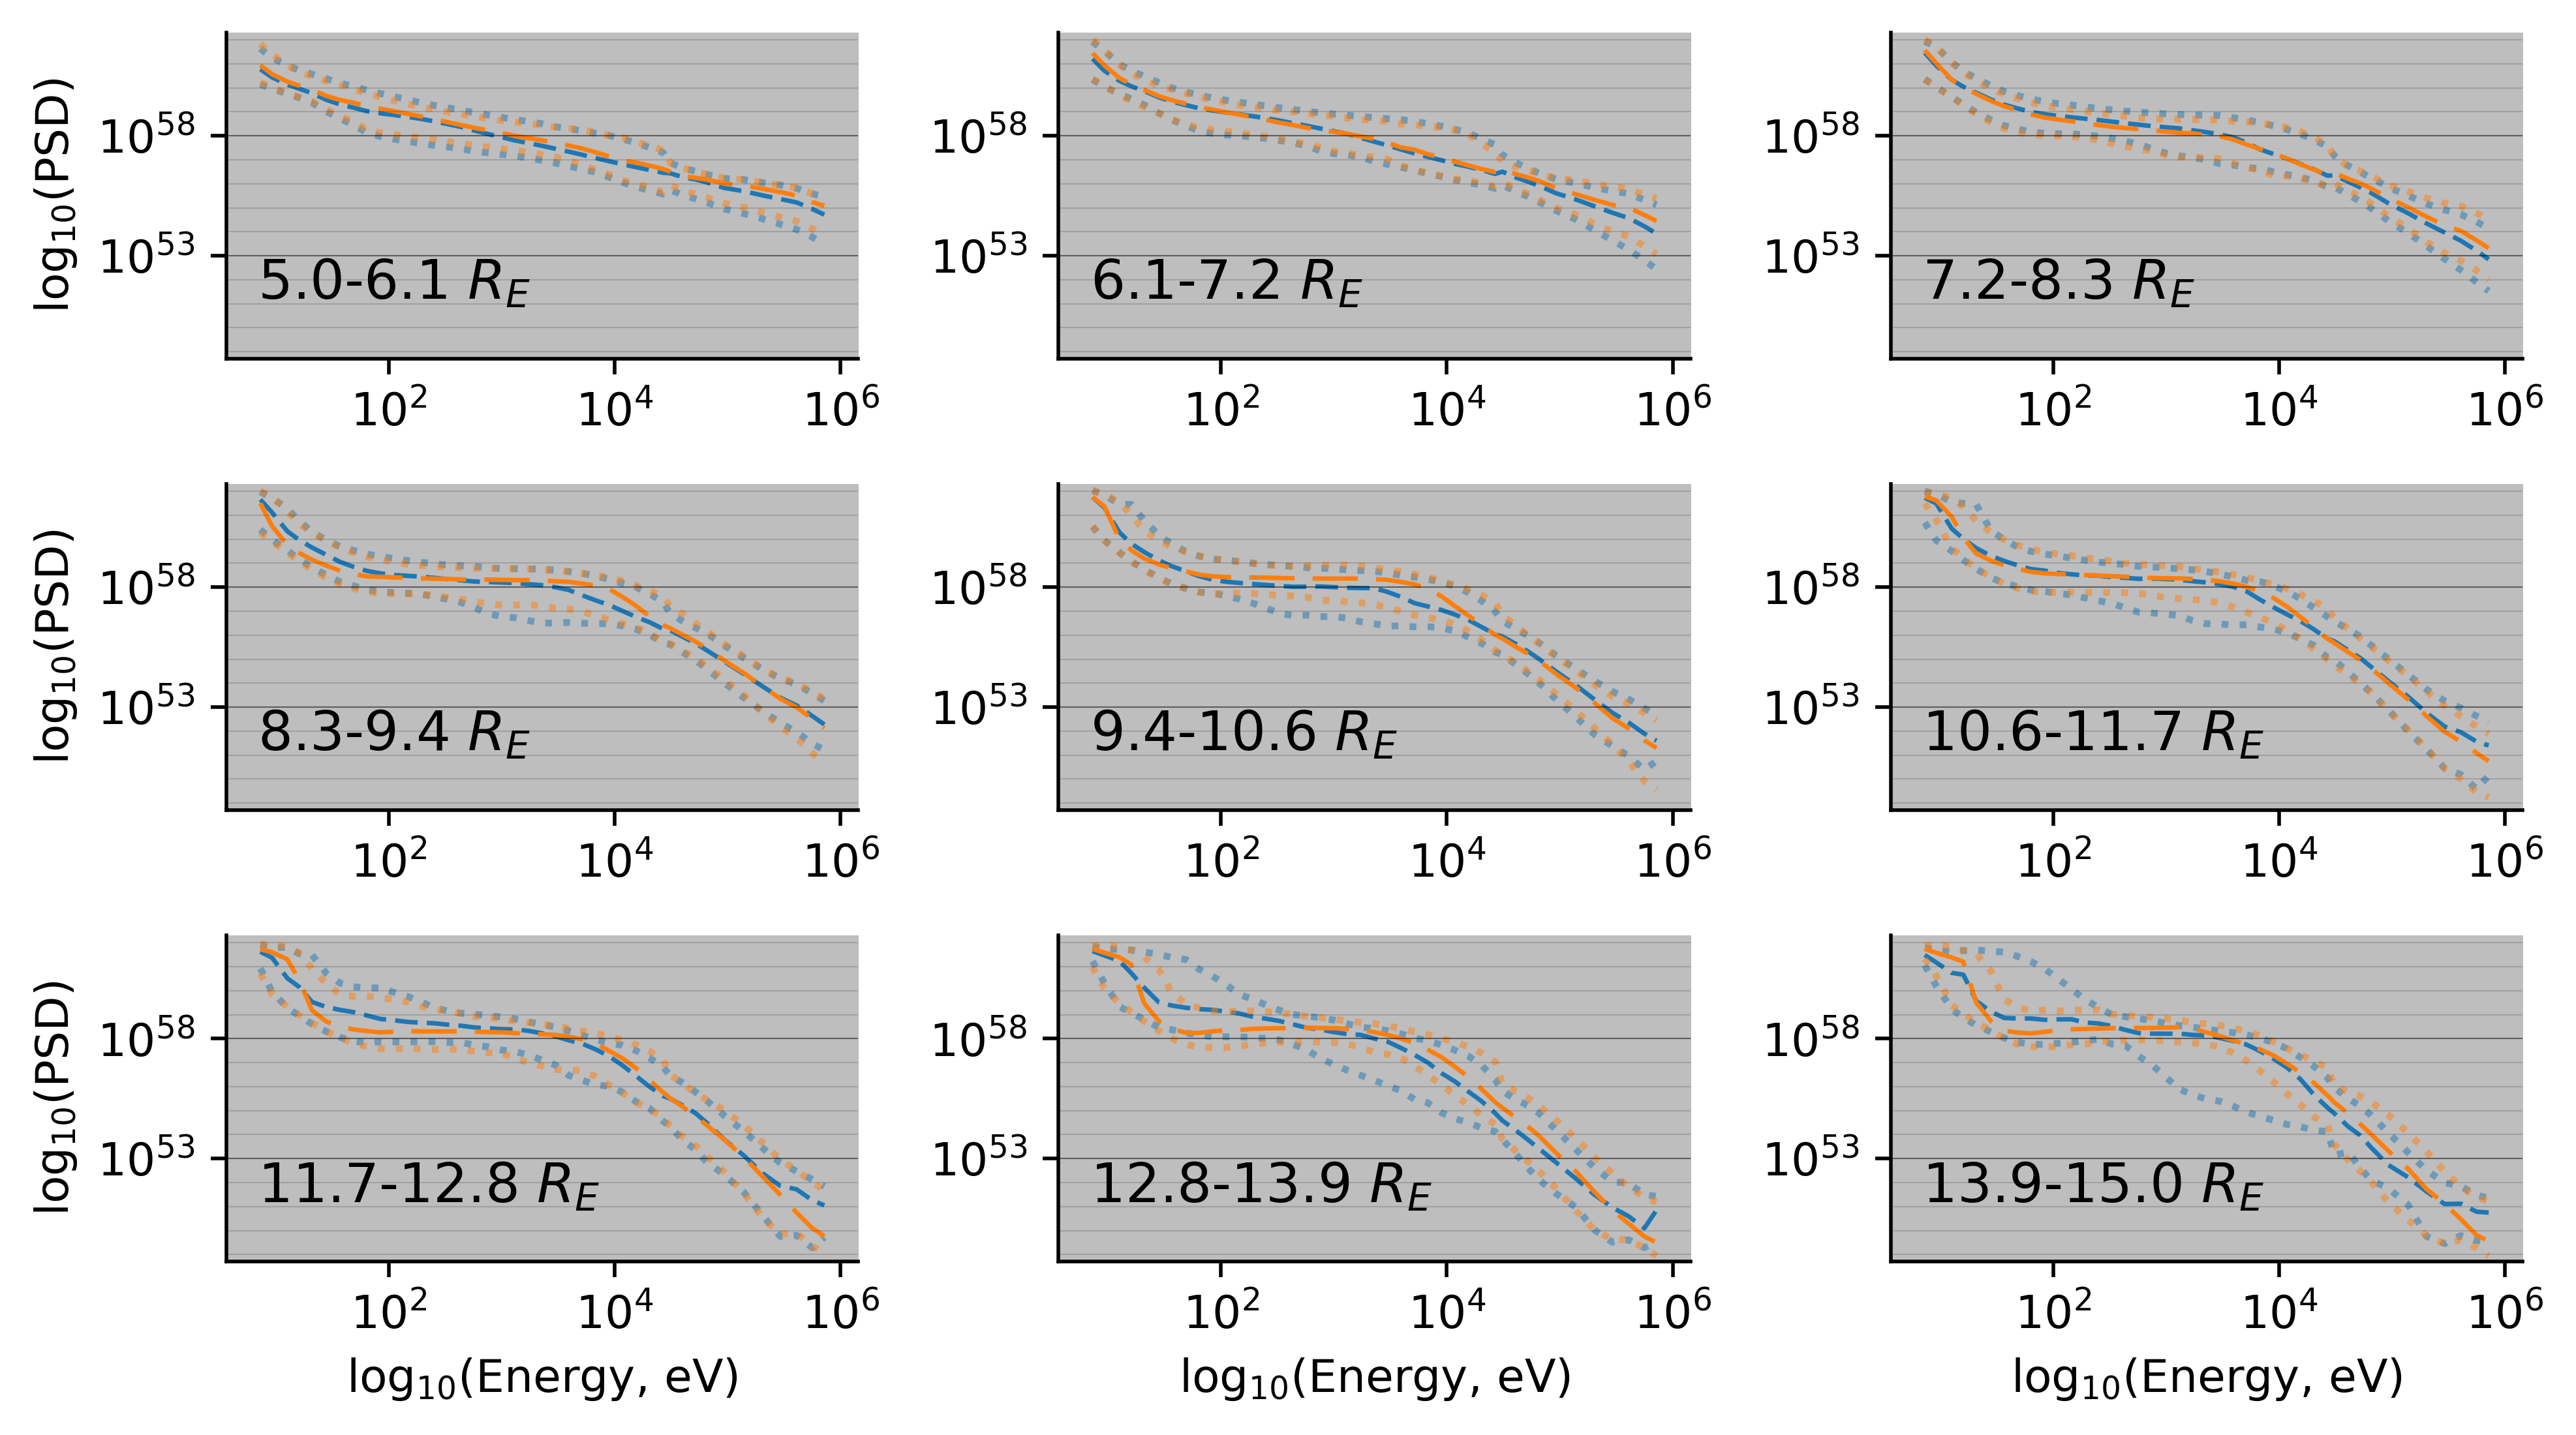

In [53]:
fig = plt.figure(figsize=(8,4.5),dpi=500)
axs = [plt.subplot(3,3,i+1) for i in range(9)]

# Plotting dawn medians
[i.plot(e_levs2,r_def_da[j],c='C0',linewidth=1,linestyle='--',dashes=(5,2))
 for i,j in zip(axs,range(9))]
[i.plot(e_levs2,da_ql[j],c='C0',linestyle=':',alpha=0.5) for i,j in zip(axs,range(9))]
[i.plot(e_levs2,da_qu[j],c='C0',linestyle=':',alpha=0.5) for i,j in zip(axs,range(9))]

#######

# Plotting dusk medians
[i.plot(e_levs2,r_def_du[j],c='C1',linewidth=1,linestyle='--',dashes=(10,4))
 for i,j in zip(axs,range(9))]
[i.plot(e_levs2,du_ql[j],c='C1',linestyle=':',alpha=0.5) for i,j in zip(axs,range(9))]
[i.plot(e_levs2,du_qu[j],c='C1',linestyle=':',alpha=0.5) for i,j in zip(axs,range(9))]

#######

[i.fill_between([min(e_levs2)/5,max(e_levs)*5],
                [1e+47]*2,[1e+64]*2,
                color='C7',alpha=0.5) for i in axs]

#######

# Adding Gridlines to the y-axis
majt = [53,58]
mint = np.arange(48,64,1)
alphas = [0.5 if i in majt else 0.15 for i in mint]

[i.plot([min(e_levs2)/2,max(e_levs2)*2],[1e+48*10**j,1e+48*10**j],
        c='k',alpha=k,linewidth=0.3)
 for i in axs for j,k in zip(np.arange(0,16,1),alphas)]

#######

[i.set_ylim(5e+48,2e+62) for i in axs]
[i.set_xlim(min(e_levs2)/2,max(e_levs)*2) for i in axs]
[i.set_xscale('log') for i in axs]
[i.set_yscale('log') for i in axs]
[i.set_title(str(j)+'-'+str(k)+' $R_E$',position=(0.05,0.1),loc='left')
 for i,j,k in zip(axs,np.around(r_bins[:-1],1),np.around(r_bins[1:],1))]
[i.set_ylabel('log$_{10}$(PSD)') for i in axs[::3]]
[i.set_xlabel('log$_{10}$(Energy, eV)') for i in axs[-3:]]

sbn.despine()
plt.tight_layout()

path = '/home/users/hf832176/My Documents/Coding/themis/Graphs/write_up/'
plt.savefig(fname = path+'PSDvE_bin_avg.pdf',format='pdf',bbox_inches='tight')
# plt.savefig(fname = path+'PSDvE_bin_avg.eps',format='eps',bbox_inches='tight')
plt.savefig(fname = path+'PSDvE_bin_avg.png',format='png',bbox_inches='tight')

plt.show()
# plt.close(fig)

In [30]:
initwidth = 0.06
wlims = np.array([[i-initwidth/2,i+initwidth/2] for i in np.log10(e_levs2)])
wlimlog = 10**wlims
logwidths = wlimlog[:,1]-wlimlog[:,0]

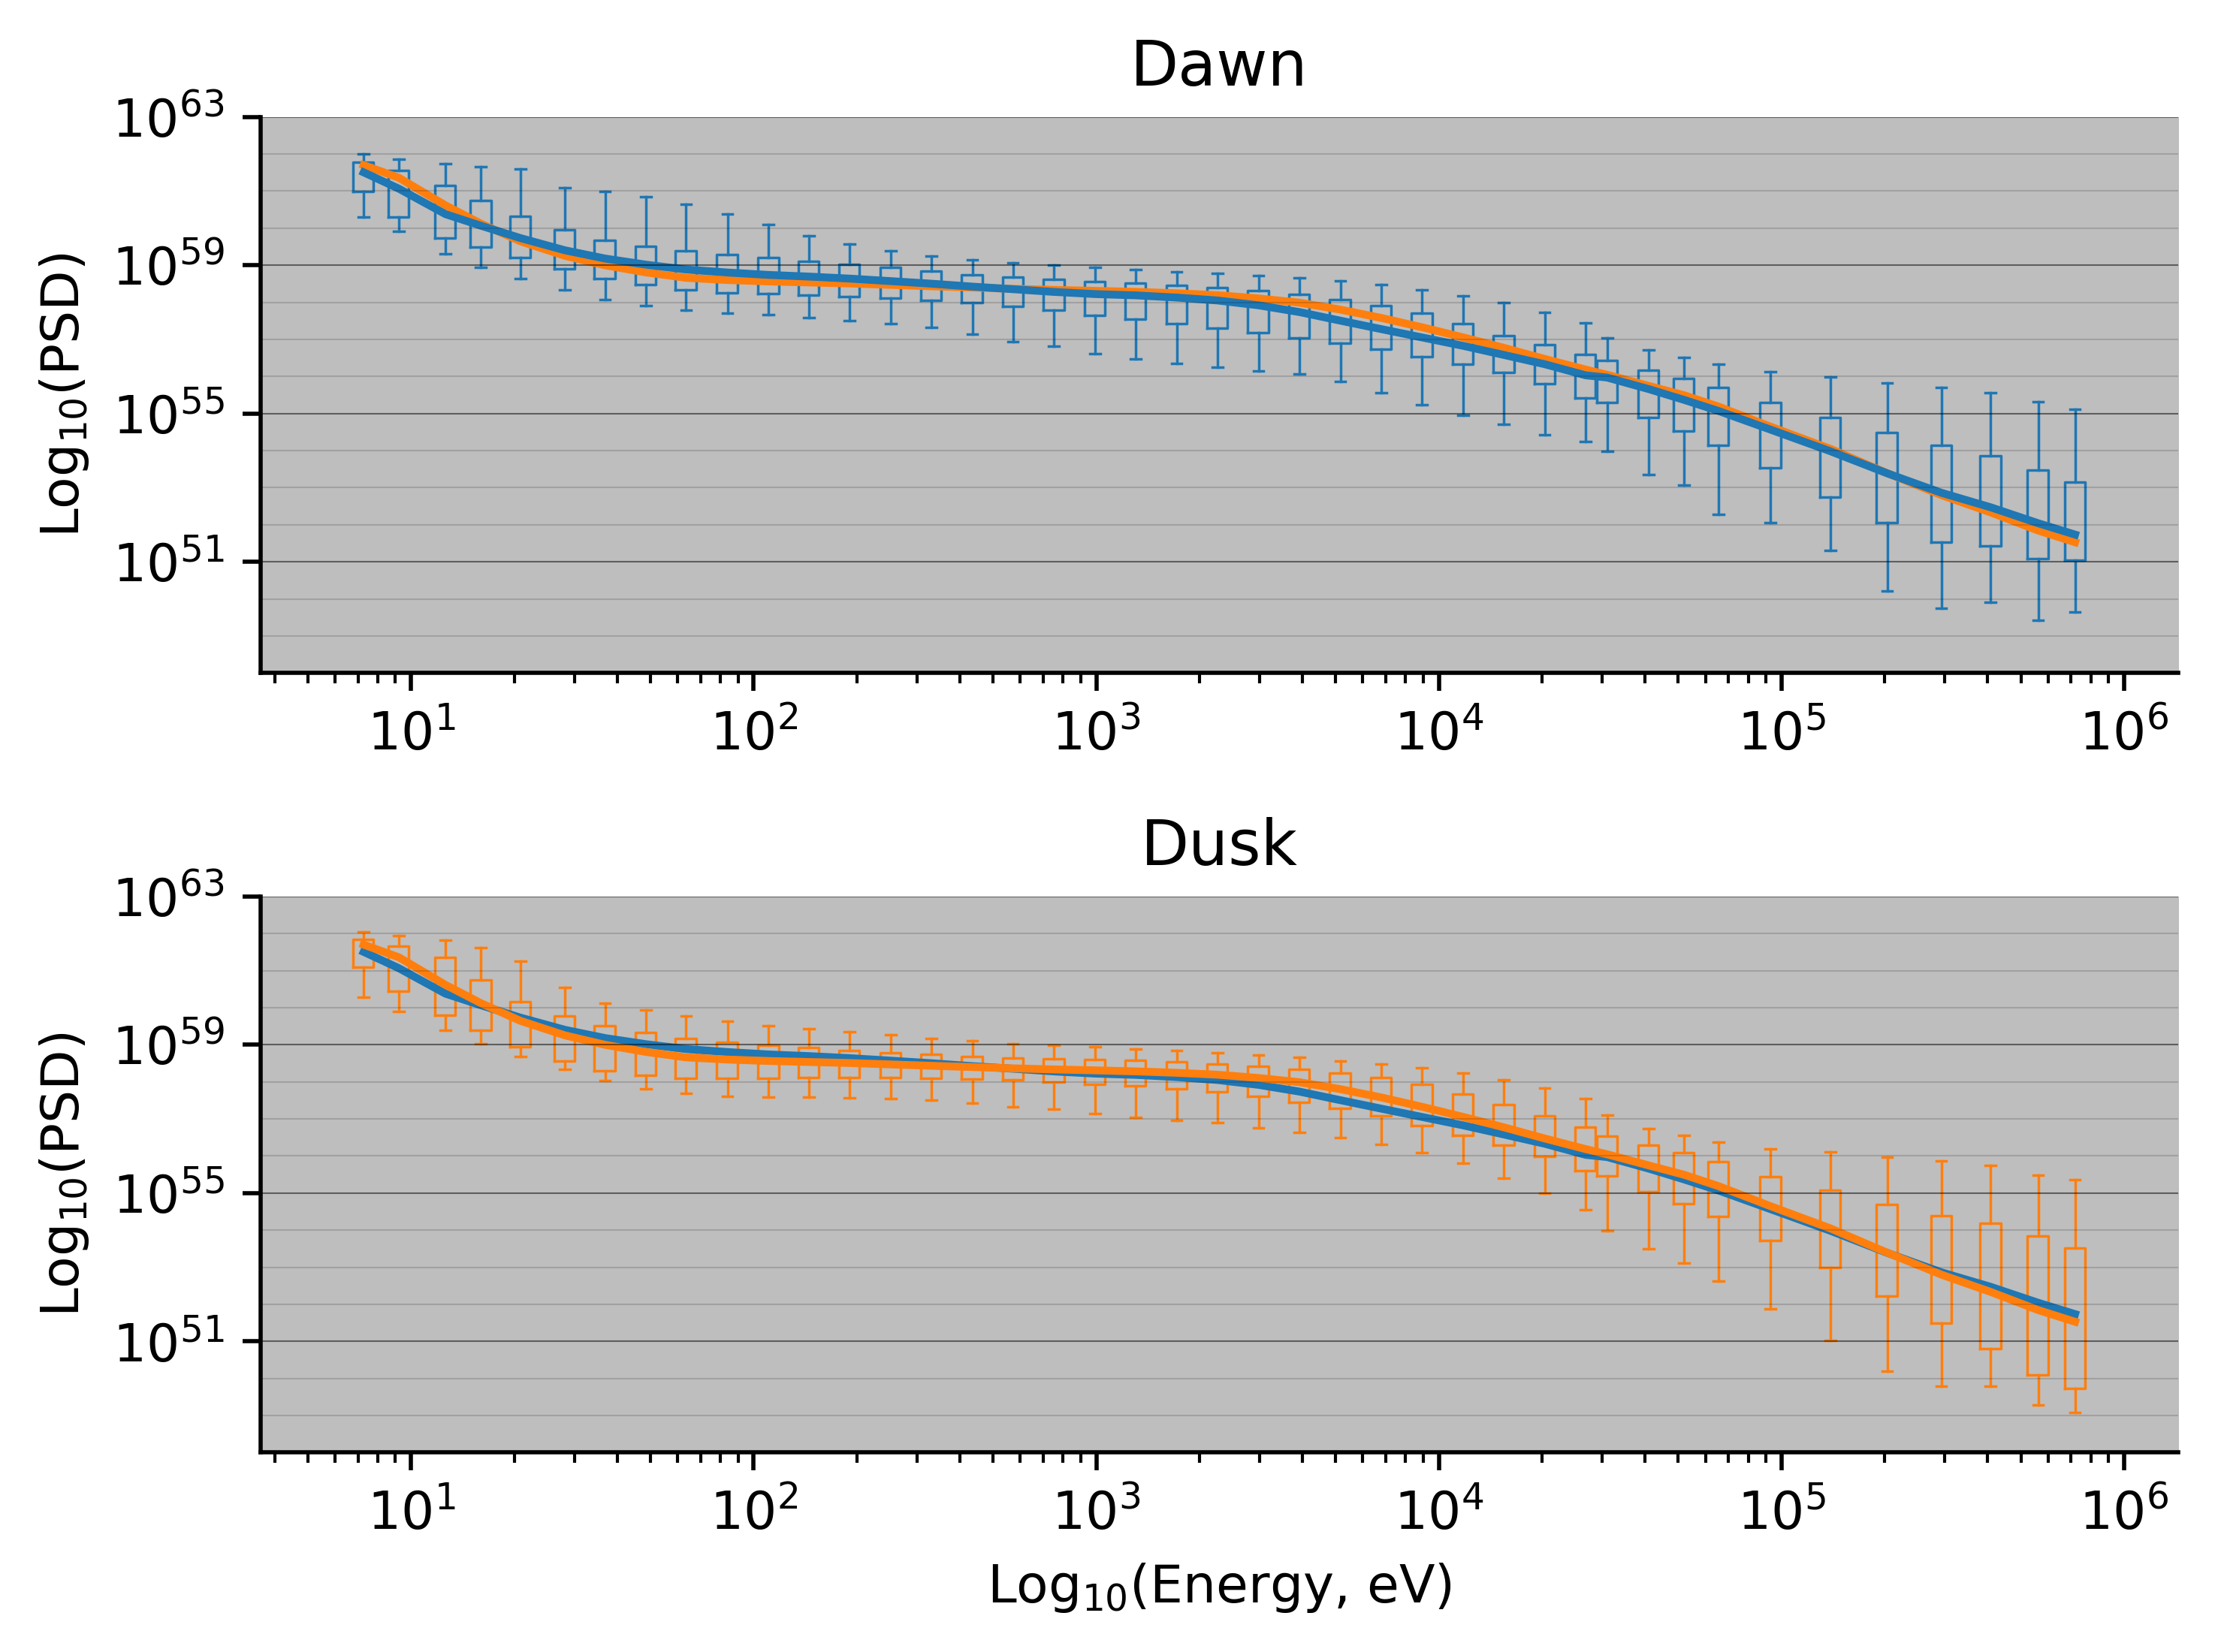

In [52]:
# Plotting boxplots of log10(DEF) for all energies.
plt.figure(figsize=(6,4.5),dpi=500)
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

dawn_args = {'widths':logwidths,'sym':'','whis':[5,95],
             'positions':e_levs2,
             'medianprops':dict(linewidth=0),
             'boxprops':dict(color='C0',linewidth=0.5),
             'whiskerprops':dict(color='C0',linewidth=0.5),
             'capprops':dict(color='C0',linewidth=0.5)}

dusk_args = {'widths':logwidths,'sym':'','whis':[5,95],
             'positions':e_levs2,
             'medianprops':dict(linewidth=0),
             'boxprops':dict(color='C1',linewidth=0.5),
             'whiskerprops':dict(color='C1',linewidth=0.5),
             'capprops':dict(color='C1',linewidth=0.5)}

#######

ax1.boxplot(dawn_f5.iloc[:,71:].values,**dawn_args)
ax1.plot(e_levs2,dusk_f5.iloc[:,71:].median(),c='C1')
ax1.plot(e_levs2,dawn_f5.iloc[:,71:].median(),c='C0')

# ax1.grid(axis='y',alpha=0.5)

ax1.set_title('Dawn')
ax1.set_ylabel('Log$_{10}$(PSD)')
# plt.xlabel('Log$_{10}$(Energy)')
# ax1.set_xticks(np.arange(1,43,3))
# ax1.set_xticklabels(["{0:.2f}".format(i) for i in np.log10(e_levs2[::3])])
ax1.set_ylim(1e+48,1e+63)
ax1.set_xlim(min(e_levs2)/2,max(e_levs2)*2)
ax1.set_yscale('log')
ax1.set_xscale('log')

#######

ax2.boxplot(dusk_f5.iloc[:,71:].values,**dusk_args)
ax2.plot(e_levs2,dawn_f5.iloc[:,71:].median(),c='C0')
ax2.plot(e_levs2,dusk_f5.iloc[:,71:].median(),c='C1')

#######

# Adding Gridlines to the y-axis
majt = np.arange(48,64,1)[3::4]
mint = np.arange(48,64,1)
alphas = [0.5 if i in majt else 0.15 for i in mint]

[i.plot([min(e_levs2)/2,max(e_levs2)*2],[1e+48*10**j,1e+48*10**j],
        c='k',alpha=k,linewidth=0.3)
 for i in [ax1,ax2] for j,k in zip(np.arange(0,16,1),alphas)]

#######

ax2.set_title('Dusk')
ax2.set_ylabel('Log$_{10}$(PSD)')
ax2.set_xlabel('Log$_{10}$(Energy, eV)')
# ax2.set_xticks(np.arange(1,43,3))
# ax2.set_xticklabels(["{0:.2f}".format(i) for i in np.log10(e_levs2[::3])])
ax2.set_ylim(1e+48,1e+63)
ax2.set_xlim(min(e_levs2)/2,max(e_levs2)*2)
ax2.set_yscale('log')
ax2.set_xscale('log')

ax1.fill_between([min(e_levs2)/5,max(e_levs)*5],
                 [1e+47]*2,[1e+64]*2,
                 color='C7',alpha=0.5)
ax2.fill_between([min(e_levs2)/5,max(e_levs)*5],
                 [1e+47]*2,[1e+64]*2,
                 color='C7',alpha=0.5)

plt.tight_layout()
sbn.despine()

path = '/home/users/hf832176/My Documents/Coding/themis/Graphs/write_up/'
plt.savefig(fname = path+'PSDvE_dd_avg.pdf',format='pdf',bbox_inches='tight')
# plt.savefig(fname = path+'PSDvE_dd_avg.eps',format='eps',bbox_inches='tight')
plt.savefig(fname = path+'PSDvE_dd_avg.png',format='png',bbox_inches='tight')

plt.show()

# <center> Kolmogorov-Smirnov Statistic </center>

In [33]:
from scipy.stats import ks_2samp as kss

In [34]:
# Critical KS stat at the p={0.05,0.001} level
ks_crit5 = 1.36*np.sqrt(2*len(dusk_f5)/(len(dusk_f5)**2))
ks_crit01 = 1.95*np.sqrt(2*len(dusk_f5)/(len(dusk_f5)**2))
print(ks_crit5,ks_crit01)

# If stat > critical value then distributions are different.

0.005334358875758605 0.007648529270389177


In [35]:
ks_df = pd.DataFrame(index = [i for i in dusk_f5.columns[71:]],
                     columns=['stat','p-val'])

ks_df['stat'] = [kss(dusk_f5[i],dawn_f5[i])[0] for i in dusk_f5.columns[71:]]
ks_df['p-val'] = [kss(dusk_f5[i],dawn_f5[i])[1] for i in dusk_f5.columns[71:]]
ks_df['p-val'] = ['<1e-10' if i < 1e-10 else i for i in ks_df['p-val']]
# ks_df

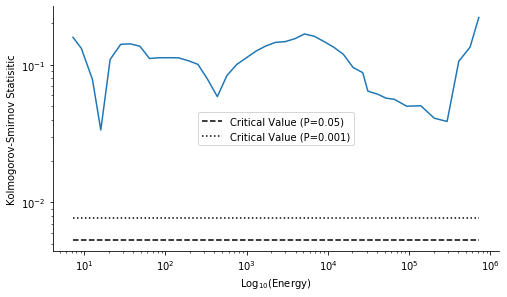

In [41]:
plt.figure(figsize=(8,4.5))
plt.plot(e_levs2,ks_df.stat)

xlims = [min(e_levs2),max(e_levs2)]
plt.plot(xlims,[ks_crit5,ks_crit5],'k--',label='Critical Value (P=0.05)')
plt.plot(xlims,[ks_crit01,ks_crit01],'k:',label='Critical Value (P=0.001)')

plt.ylabel('Kolmogorov-Smirnov Statisitic')
plt.xlabel('Log$_{10}$(Energy)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
sbn.despine()
plt.show()

# <center> Anderson-Darlin Test </center>

In [37]:
from scipy.stats import anderson_ksamp as adt

In [38]:
# AD stat critical values for
# P={0.25,0.10,0.05,0.025,0.01,0.005,0.001}

AD_crit = adt([dusk_f5.iloc[:,71],
               dawn_f5.iloc[:,71]])[1]

# If AD stat > crit value, different dists

<ipython-input-38-888c193f3908>:4: UserWarning: p-value floored: true value smaller than 0.001
  AD_crit = adt([dusk_f5.iloc[:,71],


In [39]:
ad_df = pd.DataFrame(index = [i for i in dusk_f5.columns[71:]],
                     columns=['stat','p-val'])

ad_df['stat'] = [adt([dusk_f5[i],dawn_f5[i]])[0] for i in dusk_f5.columns[71:]]
# ad_df['crit val'] = [adt([dawn[i],dusk[i]])[1] for i in dusk.columns[0:11]]
ad_df['p-val'] = [adt([dusk_f5[i],dawn_f5[i]])[2] for i in dusk_f5.columns[71:]]
ad_df['p-val'] = ['<1e-10' if i < 1e-10 else i for i in ad_df['p-val']]
# ad_df

<ipython-input-39-9384624c7b69>:4: UserWarning: p-value floored: true value smaller than 0.001
  ad_df['stat'] = [adt([dusk_f5[i],dawn_f5[i]])[0] for i in dusk_f5.columns[71:]]
<ipython-input-39-9384624c7b69>:6: UserWarning: p-value floored: true value smaller than 0.001
  ad_df['p-val'] = [adt([dusk_f5[i],dawn_f5[i]])[2] for i in dusk_f5.columns[71:]]


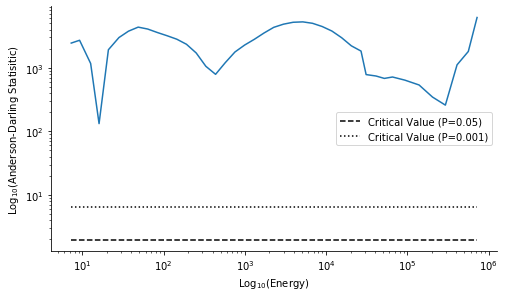

In [40]:
plt.figure(figsize=(8,4.5))
plt.plot(e_levs2,ad_df.stat)

xlims = [min(e_levs2),max(e_levs2)]
plt.plot(xlims,[AD_crit[2],AD_crit[2]],'k--',label='Critical Value (P=0.05)')
plt.plot(xlims,[AD_crit[-1],AD_crit[-1]],'k:',label='Critical Value (P=0.001)')

plt.ylabel('Log$_{10}$(Anderson-Darling Statisitic)')
plt.xlabel('Log$_{10}$(Energy)')
plt.yscale('log')
plt.xscale('log')
plt.legend()
sbn.despine()
plt.show()